# Data preprocessing and tree-based models
## Introduction
This practical will address the following topics:
1. Typical **data preprocessing** steps (handling missing values, normalization, dealing with categorical variables).
2. A **vanilla implementation** of the **K-Nearest Neighbors (KNN)** algorithm for regression.
3. Regression with tree-based models: **regression trees** and **Random forests**
4. **Feature importances** in tree-based models.
5. **Scikit-learn pipelines** to combine preprocessing and modeling into a single object.

### Data preprocessing overview
Data preprocessing is the foundation of any successful machine learning project. Many Machine Learning models see their performances degraded when trained on poorly preprocessed data. Key steps include:

- **Handling Missing Values**: Missing data can bias results if not addressed. This problem affects many models—such as linear models, support vector machines (SVMs), and neural networks—but it is particularly critical for distance-based algorithms like KNN where missing feature values can disrupt the calculation of distances, leading to inaccurate outcomes. Common strategies for handling missing values include:
  
  - *Dropping* rows/columns with missing data.
  - *Imputing* missing data using simple statistics (mean, median) or more sophisticated methods like **`KNNImputer`**.<br><br>
- **Normalization / Scaling**: Many algorithms assume features are on similar scales. Without proper scaling, features with larger numerical ranges may dominate those with smaller ranges, potentially biasing the model's results. Common scaling strategies include:
  - *Standardization*: Transform features to have zero mean and unit variance.
  - *Min-Max Scaling*: Scale features to a fixed $[0,1]$ range.<br><br>
- **Dealing with Categorical Variables**: Categorical variables must be converted to a numeric representation that preserves meaningful differences. Common strategies for dealing with categorical variables include:
  - *Label Encoding*: Assign an integer to each category (useful if there is an **ordinal** relationship).
  - *One-Hot Encoding (Dummy Encoding)*: Create a new binary column for each category (common for **nominal** features). This approach can cause a significant increase in input dimensionality (see the curse of dimensionality).

### K-Nearest Neighbors

The *$K$-Nearest Neighbors* (KNN) algorithm is a **local modeling** approach that infers its prediction from the data points closest (in some metric) to a query. Suppose we have a training set of inputs $\{x_i\}$ with associated labels or targets $\{y_i\}$. For a new query point $q$:

1. **Distance computation**: Compute the distance (e.g., Euclidean) between $q$ and each training example $x_i$.
2. **Ranking**: Sort or rank the training points by increasing distance to $q$.
3. **Neighborhood selection**: Identify the subset of the $K$ nearest neighbors $\{x_{[1]}, \dots, x_{[K]}\}$ where $y_{[i]}$ denotes the label of neighbor $x_{[i]}$.
4. **Regression or classification**: KNN can be viewed as a local estimator of the conditional expectation $\mathbb{E}[y|x=q]$.<br>For **regression** tasks, the simplest approach is to average the targets of the $K$ nearest neighbors:

$$
\hat{y}(q) = \frac{1}{K}\sum_{i=1}^{K} y_{[i]}.
$$

Alternatively, a local linear model may be used:

$$
\hat{y}(q) = \hat{a}^T q + \hat{b},
$$

where $\hat{a}$ and $\hat{b}$ are estimated (locally) by least-squares on the neighbors.
<br><br>For **classification**, one can estimate the conditional probability of belonging to a specific class (e.g., class "1") by the proportion of neighbors labeled "1":

$$
\hat{p}_1(q) = \frac{1}{K}\sum_{i=1}^{K} y_{[i]}.
$$

A threshold (e.g., 0.5) can then be used to decide the class label.

A key hyperparameter here is $K$. A *smaller* $K$ reduces bias but increases variance, while a *larger* $K$ produces a smoother model at the risk of higher bias. KNN’s performance also heavily depends on the distance metric, especially when features have different scales or include categorical variables (which may require specialized encodings or distance definitions).

### Regression trees

Regression trees rely on a tree-based structure of *internal nodes* (where decisions are made) and *terminal nodes* (leaves), which partition the input space into **mutually exclusive** regions, each associated with a simple (often constant) local model. Its construction begins with a **tree growing** phase: starting from the root node that contains all data, we recursively choose a split that best reduces the empirical error. Specifically, for a node $t$ containing $N(t)$ samples, we define

$$
R_{\mathrm{emp}}(t) \;=\; \min_{\alpha_t} \sum_{i=1}^{N(t)} L\bigl(y_i,\;h_t(x_i,\;\alpha_t)\bigr),
$$

where $L$ is typically the squared error $(y - \hat{y})^2$ for regression. Given a potential split $s$ dividing $t$ into children $t_l$ and $t_r$, we consider the decrease in empirical error:

$$
\Delta E(s,\;t) \;=\; R_{\mathrm{emp}}(t)\;-\;\bigl(R_{\mathrm{emp}}(t_l)\;+\;R_{\mathrm{emp}}(t_r)\bigr).
$$

We choose the split $s^*$ maximizing $\Delta E$, partition the dataset accordingly, and repeat the procedure recursively until no further improvement is found or a stopping criterion is met. This exhaustive splitting often yields a **very large** tree that overfits the data.

To address overfitting, a **cost-complexity pruning** procedure is commonly used. Introducing a complexity parameter $\lambda \ge 0$ that penalizes the number of leaf nodes, we define the cost-complexity measure:

$$
R_{\lambda}(T) = R_{\mathrm{emp}}(T) + \lambda \, |T|,
$$

where $|T|$ is the number of terminal nodes (leaves) in tree $T$.

- By gradually increasing $\lambda$, we obtain a *sequence* of subtrees:

$$
T_{\max} \supset T_{L-1} \supset \dots \supset T_2 \supset T_1.
$$

Each has fewer leaves. We consider all admissible subtrees $T_t \subset T$ of the large tree and compute the smallest

$$
\lambda_t = \frac{R_{\mathrm{emp}}(T) - R_{\mathrm{emp}}(T_t)}{|T| - |T_t|}
$$

that yields a lower cost. We select the subtree that **minimizes** $R_{\lambda}(T)$ (the best balances between empirical error and model complexity).
- The final tree structure is typically chosen via cross-validation or held-out validation to find the best $\lambda$.

Below is a short snippet demonstrating how to initialize a **DecisionTreeRegressor** in `sklearn` with default parameters (such as `max_depth`, `min_samples_split`, etc.):

```python
from sklearn.tree import DecisionTreeRegressor

tree_reg_example = DecisionTreeRegressor(
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,             
    min_samples_leaf=1,              
    random_state=42                  
)
```
This model is then grown with the standard CART algorithm described above.

For a more visual representation of tree-based models, an animated version of decision trees (classification) can be found [here](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/).

### Random Forests

A **Random Forest** (RF) is an ensemble learning technique designed to reduce the variance of decision trees by combining two main ideas:

1. **Bootstrap Sampling** (Bagging): We generate $B$ *bootstrap* datasets, each by sampling (with replacement) from the original training data.
2. **Random Feature Selection** (Feature Bagging): At each split, a *random subset* of $n' < n$ features is chosen, and the best split is found *only among those $n'$ features*.

Hence, each tree $h_b(\mathbf{x}, \alpha_b)$ is built from a *different* resampled dataset **and** uses only a random subset of features at each split. As a result, the trees are more **decorrelated** and often are *not pruned* heavily.

Formally, for a regression task:

$$
  h_{\mathrm{rf}}(\mathbf{x}) = \frac{1}{B} \sum_{b=1}^{B} h_b(\mathbf{x}, \alpha_b),
$$

i.e., the **average** of all tree predictions. (In classification, we take the majority vote.)

#### Why does this reduce variance?

Suppose each tree $h_b$ has variance $\sigma^2$ and they have pairwise correlation $\rho$. The variance of the RF predictor $h_{\mathrm{rf}}$ can be approximated as:

$$
  \mathrm{Var}[h_{\mathrm{rf}}] \approx \frac{(1 - \rho)\,\sigma^2}{B} + \rho\,\sigma^2,
$$

which shows that **increasing** $B$ (the number of trees) reduces the first term, while **lowering** the correlation $\rho$ among trees reduces overall variance. Random feature selection helps reduce $\rho$, because each tree sees a different subset of features.

#### Main Hyperparameters

1. $B$: the number of trees in the forest.  
2. $n'$: the number of randomly selected features at each split (often $\sqrt{n}$ by default in classification).  
3. **Tree parameters**: e.g., maximum depth, minimum samples per leaf, etc.

In practice, random forests typically provide strong performance out of the box and are less sensitive to hyperparameter tuning compared to single trees or more complex models. They also allow computing a useful estimate of **feature importance** by measuring, for each variable, how much it contributes to the cost function improvement across all splits in all trees.

Below is a short snippet demonstrating how to **initialize a RandomForestRegressor** in `sklearn` with default values:
```python
from sklearn.ensemble import RandomForestRegressor

forest_reg_example = RandomForestRegressor(
    n_estimators=100,    # number of trees
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    random_state=42
)
```
All of these parameters correspond to the concepts introduced in the sections above.

### Feature importances

Most scikit-learn models allows you to estimate how each feature contribues to the final prediction. For example, for tree-based models, both **DecisionTreeRegressor** and **RandomForestRegressor** in scikit-learn store a `feature_importances_` attribute after fitting. This gives an estimate of how much each feature contributed to reducing the split criterion (e.g., MSE). Here’s a quick example using a fitted model:
```python
# Suppose we have a fitted random forest model: forest_reg_example.fit(X, y)
import matplotlib.pyplot as plt
import numpy as np

feature_names = ["Feature1", "Feature2", "Feature3"]  # adapt to your data
importances = forest_reg_example.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()
```
The resulting bar plot helps visualize which features were most important for the splits (on average) across the forest. A single decision tree also offers a similar `feature_importances_` vector but typically is less robust than the ensemble measure.

### Scikit-learn Pipelines

Pipelines in scikit-learn let us combine **data preprocessing** (e.g., imputation, scaling) and **model training** (e.g., a random forest) into a single workflow object. Below is a simple example:

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Example pipeline: impute missing values with mean, then scale, then fit a linear model
example_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

print("Demonstration of how a pipeline is defined. No fitting done here.")

Demonstration of how a pipeline is defined. No fitting done here.


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor

class AddConstantTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that adds a constant value to all features.
    """
    def __init__(self, constant=0.0):
        self.constant = constant

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X + self.constant

custom_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("custom_add_constant", AddConstantTransformer(constant=1.0)),
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators=10, random_state=42))
])

# custom_pipeline.fit(X_train, y_train)
# y_pred = custom_pipeline.predict(X_test)
# print("MSE with custom transformer in pipeline:", mean_squared_error(y_test, y_pred))

### Important precision about the evaluation metric used in this practical:
In this practical, we will use the *Mean Squared Error* (MSE) as a convenient shorthand for the estimated *Mean Integrated Squared Error* $(\widehat{\mathrm{MISE}})$. Indeed, in practice, we rarely know the true MISE and instead rely on estimates obtained via techniques like $K$-fold cross-validation or leave-one-out (LOO) cross-validation. So keep in mind that when we refer to the MSE in these contexts, what we are really computing is an estimation of $\widehat{\mathrm{MISE}}$ from our data.

## Exercise 1: Data Loading, Exploration, and Preprocessing
1. Load the well-known **California Housing** regression dataset using the following function:
```python
from sklearn.datasets import fetch_california_housing
```
2. Explore the dataset (distribution, summary statistics).
3. Check for missing values. If the dataset does not contain missing values, artificially introduce some for the purpose of this exercice. Then, handle missing values by:
   - Dropping them (simple approach).
   - Imputing them (mean or median).
   - Using a more sophisticated method (e.g., `KNNImputer`).
4. Normalize the features (using e.g., `StandardScaler`). Remember that, as all processing steps, **scaling is fit on the training set** (not on the entire dataset) to avoid biasing the test set!
5. Preserve original vs. processed versions of the data for comparison.

### Dataset and exploration
For this exercise, we will use the **California Housing** dataset from `sklearn.datasets.fetch_california_housing`. It contains features related to California housing data, and the target is the average house value.

Alternatively, if you would like test your solution on other datasets, scikit-learn provides other built-in datasets, such as:
- **Diabetes** (a small dataset with 10 features for a regression task on disease progression).
- **Linnerud** (exercise/physiological data, a small multi-output regression problem).
If you want a dataset with even more features or complexity, you could consider **Ames Housing** or **Kaggle House Price**, both of which have many categorical and numeric features but may require additional steps to download or preprocess. You can also explore the **UCI Machine Learning Repository** for a wide range of tabular datasets.

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing

# Load the dataset
cal_housing = fetch_california_housing()
X_original = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y_original = pd.Series(cal_housing.target, name='Target')

print("Shape of the feature matrix:", X_original.shape)
print("Shape of the target vector:", y_original.shape)

print("\n--- Basic Info ---")
X_original.info()

print("\n--- Data Statistics (Original) ---")
display(X_original.describe())

print("\nData exploration done. Now let's handle missing values.")

Shape of the feature matrix: (20640, 8)
Shape of the target vector: (20640,)

--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB

--- Data Statistics (Original) ---


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000



Data exploration done. Now let's handle missing values.


### Handling Missing Values
Although the California Housing dataset typically does not contain missing values, let’s **artificially introduce some** missing values for demonstration. We will then show three approaches:

1. **Dropping** rows with missing values.
2. **Imputing** with mean or median.
3. **KNNImputer** or another advanced method.

#### `KNNImputer` Explanation
`KNNImputer` uses a K-Nearest Neighbors approach to fill missing entries: for each row that has missing features, it finds the nearest *k* rows (in feature space) that do not have missing values in those columns, and uses their values (e.g., average) to impute the missing ones. This can often be more accurate than a simple mean or median if the data has local structure—rows that are similar in some features are likely also similar in the others.

In [4]:
from sklearn.model_selection import train_test_split

# Artificially introduce missing values
np.random.seed(42)
missing_mask = np.random.rand(*X_original.shape) < 0.01  # ~1% missing
X_missing = X_original.copy()
X_missing[missing_mask] = np.nan

print("\n--- Number of missing values (artificial) ---")
print(X_missing.isnull().sum())

# Let's first do a simple train-test split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_missing, y_original, test_size=0.2, random_state=42
)

# 2.3.1 Dropping rows with missing values
X_train_drop = X_train_full.dropna(axis=0)
y_train_drop = y_train_full.loc[X_train_drop.index]
X_test_drop = X_test_full.dropna(axis=0)
y_test_drop = y_test_full.loc[X_test_drop.index]

print("\n--- After Dropping Missing Values ---")
print("Training set size:", X_train_drop.shape)
print("Test set size:", X_test_drop.shape)

# 2.3.2 Imputing with mean or median
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy='mean')
X_train_mean = mean_imputer.fit_transform(X_train_full)
X_test_mean = mean_imputer.transform(X_test_full)

median_imputer = SimpleImputer(strategy='median')
X_train_median = median_imputer.fit_transform(X_train_full)
X_test_median = median_imputer.transform(X_test_full)

# 2.3.3 A more sophisticated method: KNNImputer
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=3)
X_train_knn = knn_imputer.fit_transform(X_train_full)
X_test_knn = knn_imputer.transform(X_test_full)

print("\nImputation done. Now we have multiple versions of the dataset.")


--- Number of missing values (artificial) ---
MedInc        212
HouseAge      190
AveRooms      200
AveBedrms     203
Population    230
AveOccup      167
Latitude      193
Longitude     221
dtype: int64

--- After Dropping Missing Values ---
Training set size: (15246, 8)
Test set size: (3833, 8)



Imputation done. Now we have multiple versions of the dataset.


### Dealing with Categorical Values

In this dataset, we have only numerical features. However, real-world datasets often include **categorical** variables. Two popular encoding strategies are:

1. **Label Encoding**: Each category is assigned an integer.
2. **One-Hot Encoding (Dummy Encoding)**: Create a new binary column for each category.

Below is a small example using a synthetic dataframe containing a categorical column.

In [5]:
example_df = pd.DataFrame({
    "Size": ["Small", "Medium", "Large", "Medium", "Small"],
    "Weight": [1.0, 2.3, 5.5, 2.0, 1.1]
})

# 2.4.1 Label Encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
example_df["Size_label"] = label_encoder.fit_transform(example_df["Size"])

# 2.4.2 One-Hot Encoding
one_hot_df = pd.get_dummies(example_df, columns=["Size"], prefix="Size")

print("Original DataFrame with Label Encoding:")
display(example_df)
print("\nDataFrame with One-Hot Encoding:")
display(one_hot_df)

Original DataFrame with Label Encoding:


,Size,Weight,Size_label
0,Small,1.0,2
1,Medium,2.3,1
2,Large,5.5,0
3,Medium,2.0,1
4,Small,1.1,2



DataFrame with One-Hot Encoding:


,Weight,Size_label,Size_Large,Size_Medium,Size_Small
0,1.0,2,False,False,True
1,2.3,1,False,True,False
2,5.5,0,True,False,False
3,2.0,1,False,True,False
4,1.1,2,False,False,True


We'll stick to numeric data for the main practical, but this is how you'd handle categorical features.

### Normalization/Scaling

Scaling is critical for distance-based methods. We will use **`StandardScaler`**, which transforms each feature to have zero mean and unit variance.

> **Remember**: *Always fit the scaler on the **training set**, then apply the same transformation to the test set. This prevents data leakage and preserves the integrity of the test data.*

In [6]:
from sklearn.preprocessing import StandardScaler

# We'll choose the mean-imputed dataset for demonstration
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_mean)  # fit on training
X_test_scaled = scaler.transform(X_test_mean)       # transform test with the same scaler

# Another popular method: Min-Max Scaling (commented out)
# from sklearn.preprocessing import MinMaxScaler
# minmax_scaler = MinMaxScaler()
# X_train_scaled_minmax = minmax_scaler.fit_transform(X_train_mean)
# X_test_scaled_minmax = minmax_scaler.transform(X_test_mean)

# Renaming final sets
X_train_final = X_train_scaled
X_test_final = X_test_scaled
y_train_final = y_train_full
y_test_final = y_test_full

print("\nData is now scaled (fit on training set) using mean-imputed values.")


Data is now scaled (fit on training set) using mean-imputed values.


## Exercise 2: Vanilla KNN Implementation
1. Split your data into training and test sets (we should have already done that in the previous exercise).
2. Implement a vanilla KNN regressor from scratch (no scikit-learn for this part).
3. Choose a value of $k$ (e.g., 3, 5, 7).
4. Compare predictions with the true values using Mean Squared Error (MSE).

### Implementation

In [7]:
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def knn_regressor(X_train, y_train, X_test, k=3):
    """
    A simple KNN regressor (manual implementation).
    - X_train: training features (numpy array)
    - y_train: training targets (numpy array)
    - X_test: test features (numpy array)
    - k: number of neighbors to consider
    """
    predictions = []
    for test_point in tqdm(X_test):
        distances = [euclidean_distance(test_point, x_train) for x_train in X_train]
        k_indices = np.argsort(distances)[:k]
        prediction = np.mean(y_train[k_indices])
        predictions.append(prediction)
    return np.array(predictions)

for k in [3, 5, 7]:
  y_pred_knn = knn_regressor(X_train_final, y_train_final.values, X_test_final, k=k)
  mse_knn = mean_squared_error(y_test_final, y_pred_knn)
  print(f"KNN Regressor (k={k}) MSE: {mse_knn:.4f}")

  0%|          | 0/4128 [00:00<?, ?it/s]

KNN Regressor (k=3) MSE: 0.4954


  0%|          | 0/4128 [00:00<?, ?it/s]

KNN Regressor (k=5) MSE: 0.4588


  0%|          | 0/4128 [00:00<?, ?it/s]

KNN Regressor (k=7) MSE: 0.4495


## Exercise 3: Regression Trees and Random Forests
1. Train a regression tree on the training set.
2. Train a random forest on the training set.
3. Evaluate both models using MSE.
4. Compare their performance with your KNN model.
5. Determine how modifying the `max_depth` (for the regression trees) and `n_estimators` (for the random forests) impacts the performances of the model. Plot these results graphically.
6. Plot the features importance of the best model with the optimal parameters

### Implementation with Scikit-learn

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# 4.2.1 Regression Tree
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train_final, y_train_final)
y_pred_tree = tree_reg.predict(X_test_final)
mse_tree = mean_squared_error(y_test_final, y_pred_tree)
print(f"Regression Tree MSE (default parameters): {mse_tree:.4f}")

# 4.2.2 Random Forest
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train_final, y_train_final)
y_pred_forest = forest_reg.predict(X_test_final)
mse_forest = mean_squared_error(y_test_final, y_pred_forest)
print(f"Random Forest MSE (default parameters): {mse_forest:.4f}")

print("\nComparison of MSE:")
print(f"KNN (k={k}): {mse_knn:.4f}")
print(f"Decision Tree: {mse_tree:.4f}")
print(f"Random Forest: {mse_forest:.4f}")

Regression Tree MSE (default parameters): 0.5443


Random Forest MSE (default parameters): 0.2672

Comparison of MSE:
KNN (k=7): 0.4495
Decision Tree: 0.5443
Random Forest: 0.2672


### Exploring Key Parameters

#### Decision Tree: `max_depth`
We can examine how **max_depth** (the maximum number of splits from the root to the leaf) affects performance.

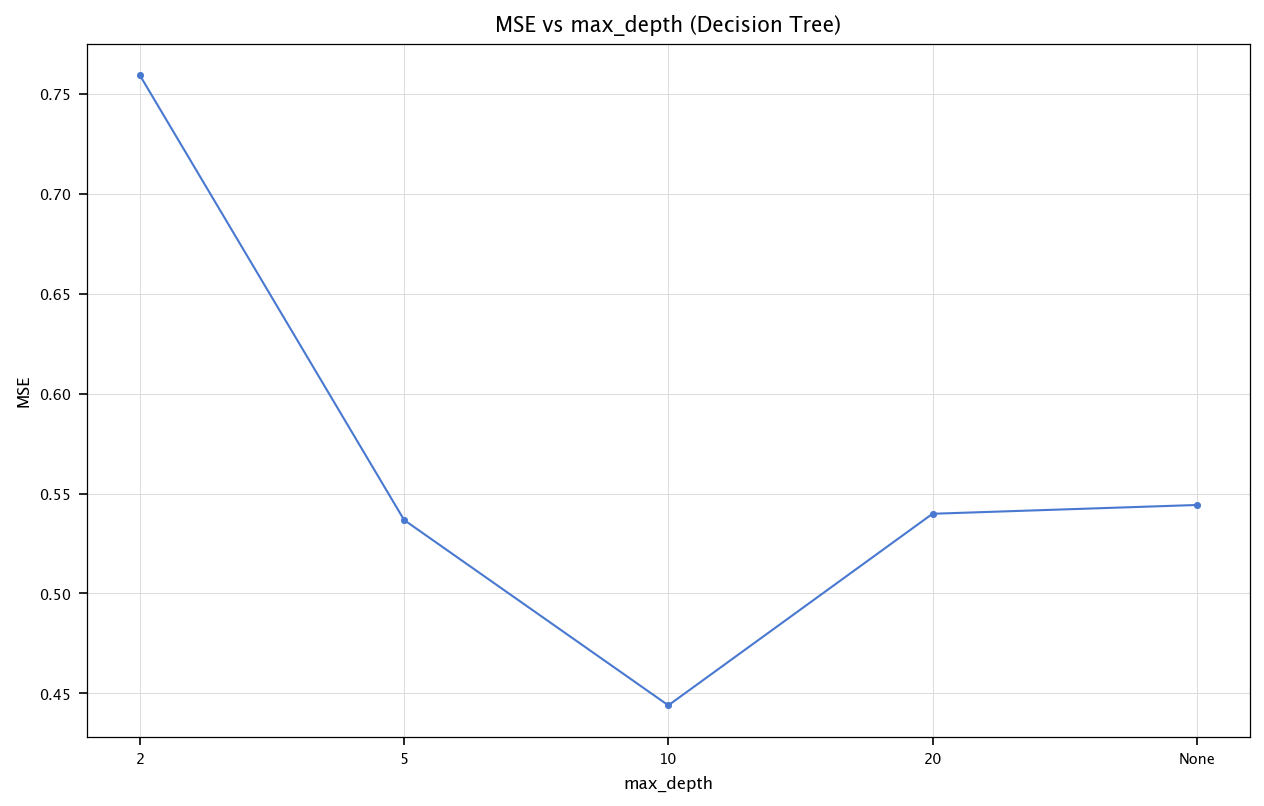

In [9]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-v0_8-muted', 'practicals.mplstyle'])

depths = [2, 5, 10, 20, None]
mse_values_tree = []

for d in depths:
    dt = DecisionTreeRegressor(max_depth=d, random_state=42)
    dt.fit(X_train_final, y_train_final)
    y_pred_dt = dt.predict(X_test_final)
    mse_values_tree.append(mean_squared_error(y_test_final, y_pred_dt))

plt.figure(figsize=(10, 6))
plt.plot([str(d) for d in depths], mse_values_tree, marker='o')
plt.title("MSE vs max_depth (Decision Tree)")
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.grid("on")
plt.show()

#### Random Forest: `n_estimators`
Similarly, we can see how **n_estimators** (the number of trees in the forest) impacts the MSE.

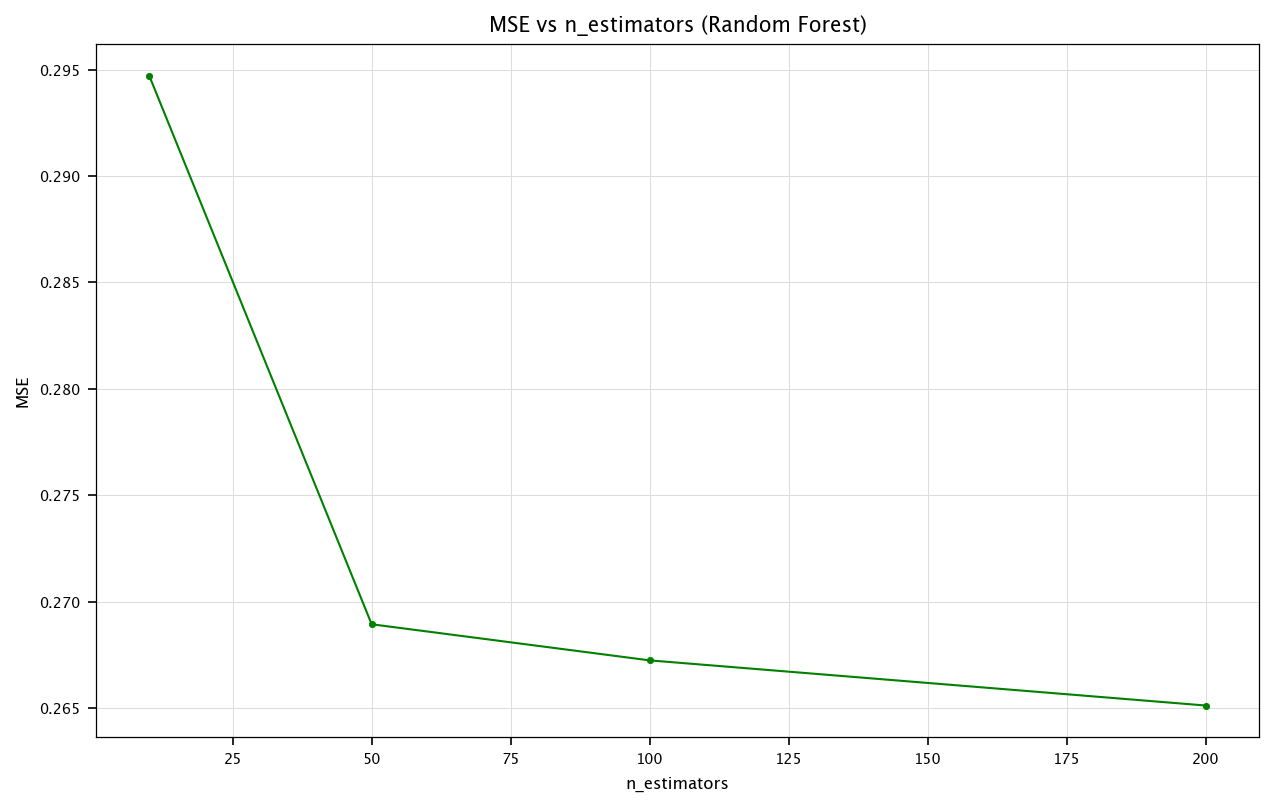

In [10]:
estimators_range = [10, 50, 100, 200]
mse_values_rf = []

for n in estimators_range:
    rf = RandomForestRegressor(n_estimators=n, random_state=42)
    rf.fit(X_train_final, y_train_final)
    y_pred_rf = rf.predict(X_test_final)
    mse_values_rf.append(mean_squared_error(y_test_final, y_pred_rf))

plt.figure(figsize=(10, 6))
plt.plot(estimators_range, mse_values_rf, marker='o', color='green')
plt.title("MSE vs n_estimators (Random Forest)")
plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.grid("on")
plt.show()

### Feature importance with the best models
Based on the experiments above, let’s define **user-chosen** parameters for the *best* (or at least improved) **Decision Tree** and **Random Forest**, then **compute and display** their feature importances.

Feel free to update `max_depth` and `n_estimators` according to the results you obtained above.

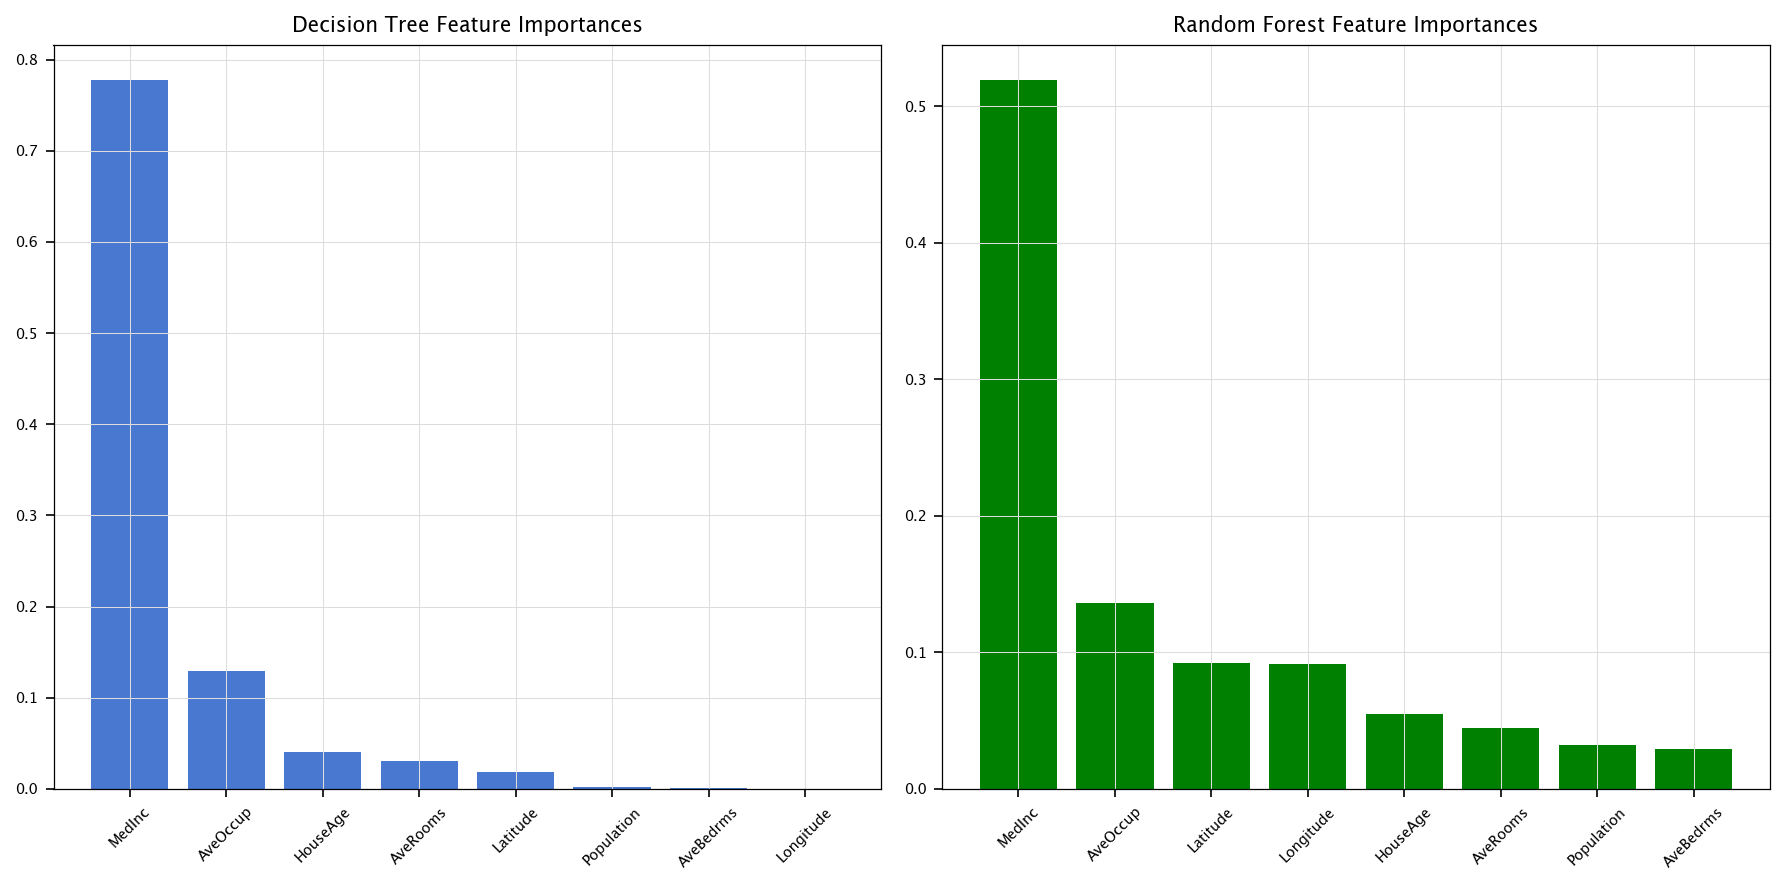

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# User-chosen parameters (edit based on the results of section 4.3)
max_depth = 5     # for the Decision Tree
n_estimators = 50 # for the Random Forest

# Instantiate and fit the best Decision Tree
best_tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
best_tree.fit(X_train_final, y_train_final)

# Instantiate and fit the best Random Forest
best_forest = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
best_forest.fit(X_train_final, y_train_final)

feature_names = X_original.columns  # Using original column names

tree_importances = best_tree.feature_importances_
forest_importances = best_forest.feature_importances_

# Sort features by importance for each model
tree_sorted_idx = np.argsort(tree_importances)[::-1]
forest_sorted_idx = np.argsort(forest_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Decision Tree Feature Importances")
plt.bar(range(len(tree_importances)), tree_importances[tree_sorted_idx], align='center')
plt.xticks(range(len(tree_importances)), feature_names[tree_sorted_idx], rotation=45)
plt.grid("on")
plt.subplot(1, 2, 2)
plt.title("Random Forest Feature Importances")
plt.bar(range(len(forest_importances)), forest_importances[forest_sorted_idx], align='center', color='green')
plt.xticks(range(len(forest_importances)), feature_names[forest_sorted_idx], rotation=45)
plt.grid("on")
plt.tight_layout()
plt.show()

## Exercise 4: Building a Pipeline
1. **Define** a pipeline that applies the preprocessing steps (e.g., imputation, scaling) and the best-performing model (from Exercise 3).
2. **Fit** this pipeline on the training data and evaluate on the test data.
3. **Observe** how scikit-learn handles transformations during `fit` and `predict`.

### Pipeline Implementation
Below, we define a pipeline that:
1. Imputes missing values with mean.
2. Scales the features.
3. Trains a random forest regressor.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

pipeline_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the pipeline on the entire training set with missing values (X_train_full)
pipeline_rf.fit(X_train_full, y_train_full)
y_pred_pipe = pipeline_rf.predict(X_test_full)
mse_pipeline_rf = mean_squared_error(y_test_full, y_pred_pipe)
print(f"Pipeline (Random Forest) MSE: {mse_pipeline_rf:.4f}")

Pipeline (Random Forest) MSE: 0.2672


## Additional exercise: bias–variance trade-off in regression with decision trees

In this exercise, you will investigate the bias–variance trade-off for decision tree regressors of varying complexity. Specifically, you will perform simulations to estimate how the depth of a decision tree influences its performance.

**Your tasks are as follows:**

1. Select a nonlinear, moderately complex target function e.g.:
   $f(x) = \sin(4\pi x) + w$ or $f(x) = \sin(2\pi x_1 x_2 x_3) + w$

2. Evaluate three decision tree regressors, each with a different complexity level:
   - **Shallow tree**: depth = 2
   - **Medium-depth tree**: depth = 6
   - **Deep tree**: depth = 20

3. Generate training datasets composed of $n_{\text{train}} = 400$ random samples:

   
   $$
   X_{\text{train}} \sim U(0,1), \quad y_{\text{train}} = f(X_{\text{train}}) + w
   $$

   
   Here, noise $w$ follows a Gaussian distribution with mean 0 and standard deviation $0.3$:

   
   $$
   w \sim \mathcal{N}(0, 0.3^2)
   $$

5. Repeat the entire training and evaluation process $n_{\text{runs}} = 100$ times. For each run, compute and store the mean squared error (MSE) using 10-fold cross-validation on the training set.

6. Evaluate your models on a test set $X_{\text{test}}$ evenly spaced in the interval $[0,1]$ (e.g., 400 points).
   - For each test point, compute predictions across all 100 simulation runs.
   - Using these predictions, compute
     - **MSE (CV)**: The average cross-validation mean squared error (which we will call $\widehat{\text{MISE}}_{\text{kfold}}$) obtained across the 100 runs.
     - **Bias\(^2\)**: Based on how far the *average prediction* per sample is from the sample's true label.
     - **Variance**: Based on the variability of predictions per sample around that sample’s mean prediction.
     - **MSE (true)**: the approximation $
\text{MSE} \approx \text{Bias}^2 + \text{Variance}.$

7. **Discussion**  
   Analyze your results to illustrate how model complexity (tree depth) affects the balance between bias and variance:
   - Identify which depth leads to underfitting (high bias, low variance).
   - Identify which depth leads to overfitting (low bias, high variance).

In [13]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
n_train = 400        # number of training samples per run
n_runs = 100        # number of simulation runs for averaging
noise_std = 0.3     # standard deviation of noise
depths = [2, 6, 20] # tree depths to evaluate
K = 10               # number of folds for K-fold cross-validation

# Define the target function f(x) = sin(4πx)
def f_func(x):
    return np.sin(4 * np.pi * x).ravel()

# Prepare a grid of test points to evaluate predictions (for bias/variance calculations)
X_test = np.linspace(0, 1, 400)[:, None]
y_true = f_func(X_test)

# Storage for predictions and CV results
predictions = {depth: np.zeros((n_runs, X_test.shape[0])) for depth in depths}
cv_mse_values = {depth: [] for depth in depths}

# Simulation over multiple runs
for i in range(n_runs):

    # Generate random training data for this run
    X_train = np.random.rand(n_train, 1)
    y_train = f_func(X_train) + np.random.normal(0, noise_std, size=n_train)

    # Train and evaluate each tree depth
    for depth in depths:

        # Train decision tree regressor
        model = DecisionTreeRegressor(max_depth=depth)
        model.fit(X_train, y_train)

        # Store predictions
        predictions[depth][i, :] = model.predict(X_test)

        # Compute K-fold CV MSE on the training set (negative MSE is returned by cross_val_score)
        cv_scores = cross_val_score(
            DecisionTreeRegressor(max_depth=depth),
            X_train, y_train,
            scoring='neg_mean_squared_error',
            cv=KFold(n_splits=K, shuffle=True, random_state=1)
        )
        cv_mse = -cv_scores.mean()
        cv_mse_values[depth].append(cv_mse)


# Known noise variance
noise_var = noise_std**2

# Initialize a dictionary to store the results
metrics = {}

for depth in depths:
    # Mean prediction over all runs at each test point
    mean_pred = np.mean(predictions[depth], axis=0)

    # Bias^2 (averaged over test points)
    bias_sq = np.mean((mean_pred - y_true)**2)

    # Variance (averaged over test points)
    variance = np.mean(np.var(predictions[depth], axis=0))

    # True MSE = Bias^2 + Variance + noise variance
    true_mse = bias_sq + variance + noise_var

    # Average CV MSE across runs
    cv_mse_mean = np.mean(cv_mse_values[depth])

    metrics[depth] = {
        "Bias^2": bias_sq,
        "Variance": variance,
        "True MSE": true_mse,
        "CV MSE": cv_mse_mean
    }

# Display the metrics in a table for each depth
metrics_df = pd.DataFrame(metrics).T  # transpose so that depth is the index
metrics_df.index.name = "Tree Depth"
# Round the values for cleaner display
metrics_df = metrics_df.round(4)
print(metrics_df)

            Bias^2  Variance  True MSE  CV MSE
Tree Depth                                    
2           0.1875    0.0996    0.3770  0.3779
6           0.0011    0.0316    0.1227  0.1243
20          0.0009    0.0886    0.1795  0.1784
